In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', figsize=(16, 9))

# Using TF Hub MobileNet for prediction

## Downloading MobileNet

In [4]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Testing on single image

MobileNet has been trained on ImageNet which classifies images into 1000 classes. We will test MobileNet on an example image of Grace Hopper, which will hopefully be recognized as a `military_unifrom`

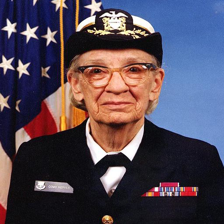

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

We have predicted the class number using `argmax`. But in order to decode this class ID into labels, we need the ImageNet labels list

## Decoding predictions

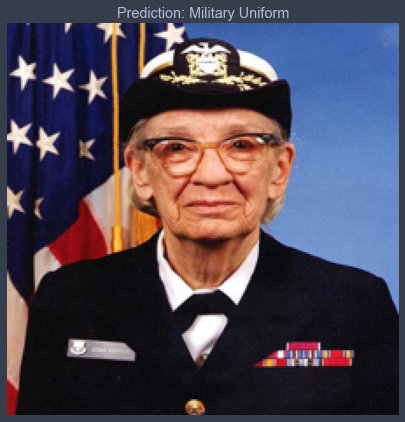

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Using MobileNet for Cats V Dogs dataset

## Downloading dataset

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True, 
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

## Reshaping the images

In [11]:
for i, example_image in enumerate(train_examples.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [12]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batch = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Running cats v dogs data on MobileNet

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['titi', 'tabby', 'Walker hound', 'American Staffordshire terrier',
       'Boston bull', 'Persian cat', 'Labrador retriever', 'malinois',
       'Shih-Tzu', 'Angora', 'Shih-Tzu', 'Great Dane', 'keeshond',
       'German shepherd', 'Border collie', 'tabby', 'Newfoundland',
       'Border collie', 'kelpie', 'Egyptian cat', 'Labrador retriever',
       'Egyptian cat', 'groenendael', 'beagle', 'lynx', 'tabby',
       'Boston bull', 'cocker spaniel', 'Pomeranian', 'golden retriever',
       'affenpinscher', 'white wolf'], dtype='<U30')

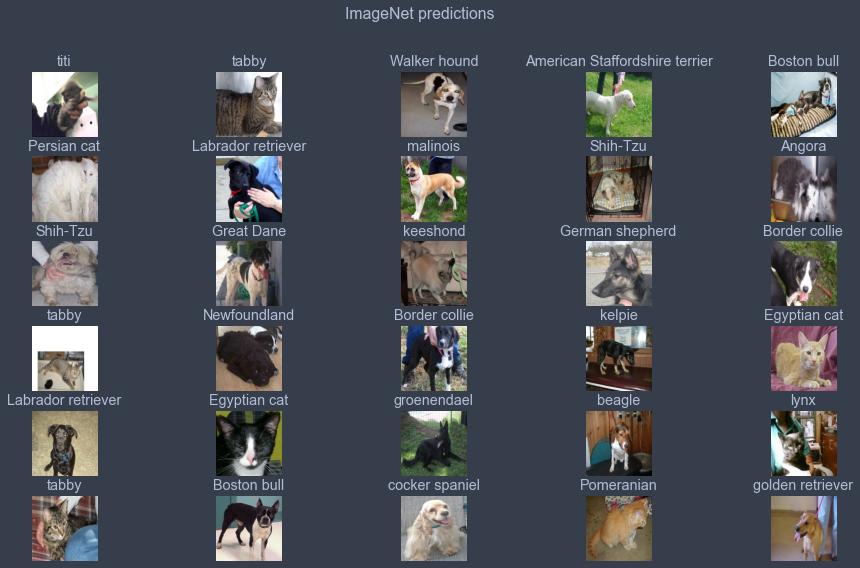

In [15]:
plt.figure(figsize=(16, 9))

for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Implement Transfer Learning

We will only download the feature vector of MobileNet from TF Hub. We do not need the final classification layer, we will make and train our own last layer

## Loading MobileNet feature vectors

In [16]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, 
                                    input_shape=(IMAGE_RES, IMAGE_RES))

In [17]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor.trainable = False